<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/Rllib_Single_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Fri Aug 26 09:30:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
try:
  import clip
  from plot_image_grid import image_grid
  import ray
except ModuleNotFoundError:
  !pip install gym==0.21.0
  !pip install git+https://github.com/openai/CLIP.git
  !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
  # !pip install ray
  !pip install https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-3.0.0.dev0-cp37-cp37m-manylinux2014_x86_64.whl
  !pip install lz4
  import clip
  from plot_image_grid import image_grid
  import ray

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [3]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from torch import cuda
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [62]:
from pytorch3d.renderer import (
  HardPhongShader
)

IMG_SIZE = (256,256)

class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()
      self._prev_position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      self._prev_position = self._position
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)

    def reset_pos(self):
      self.position = self._prev_position

class Scene():
  def __init__(self, meshes: list, azim, elev, dist):
    self.AZIM = azim
    self.ELEV = elev
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = dist
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)
    self.device = device

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value).extend(self.num_cameras)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[2.0, 5.0, 3.0]])
    # return AmbientLights(device=self.device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=self.device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=IMG_SIZE, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=HardPhongShader(
            device=self.device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [103]:
from itertools import product, groupby

DIRECTIONS = list(product(range(-1, 2), repeat=3))
ALL_DIRECTIONS = []
ALL_DIRECTIONS += [[round(a * i,2) for a in b] for b in DIRECTIONS for i in np.linspace(0.1,4,3)]
ALL_DIRECTIONS.sort()
ALL_DIRECTIONS = list(ALL_DIRECTIONS for ALL_DIRECTIONS,_ in groupby(ALL_DIRECTIONS))
ACTIONS_MAP = {
  i: ALL_DIRECTIONS[i] for i in range(len(ALL_DIRECTIONS))
}

CAMERA_CONFIG = {
  'azim': [0,0,180,180],
  'elev': [10, 45, 10, 45],
  'dist': 9.0
}

In [76]:
from copy import deepcopy
def get_scene(bg_img, objs, obs):
  objs = deepcopy(objs)
  for i, obj in enumerate(objs):
    obj.position = obs[i]
  scene = Scene([a.mesh for a in objs], **CAMERA_CONFIG)
  images = scene.render()
  new_imgs = []
  for img_ in images:
    bg_img = np.copy(np.asarray(bg_img))
    render_img = np.copy(Image.fromarray((img_[..., :3] * 255).astype('uint8')))
    threshold = render_img > 240
    render_img[threshold] = bg_img[threshold]
    new_imgs.append(render_img)
  return new_imgs, scene.scene[0]

In [175]:
import time
from gym import Env
from gym.spaces import Box, Discrete, Tuple
import random
import copy
from math import isnan
from PIL import Image
from torch import tensor
import math
import torchvision.transforms as transforms
from scipy.stats import wilcoxon, ttest_ind, ttest_rel, mannwhitneyu
from operator import itemgetter
device = "cuda" if torch.cuda.is_available() else "cpu"

class CustomTrain(Env):
  def __init__(self, limit=None):

    self.pos_space = Tuple((
      Box(-5,5,shape=(1,)),
      Box(-2,5,shape=(1,)),
      Box(-5,5,shape=(1,)),
    ))

    img_in = Image.open(f"{DATA_DIR}/images/empty_room.jpeg").convert('RGB')
    resize = transforms.Resize(IMG_SIZE)
    self.background_img = resize(img_in)

    # fruit_mesh = self.load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
    table_mesh = self.load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")
    ball_mesh = self.load_mesh(f"{DATA_DIR}/ball_mesh/ball_obj.obj")
    # fruit_object = SceneObject(fruit_mesh, scale=0.25)
    fruit_object = SceneObject(ball_mesh, scale=10)
    table_object = SceneObject(table_mesh, scale=8)
    table_object.position=[0,-3,0]

    self.model, self.preprocess = clip.load("ViT-B/32", device=device)
    self.model.cuda().eval()

    self.text_snippets = ["A basketball on the surface of a table", "A basketball bouncing off a table", "A basketball under a table", "A basketball thrown in the air above a table"]
    self.limit = limit
    self.rounds = 0
    self.total_reward = -1

    # self.camera_config = {
    #   'azim': torch.linspace(0, 180, 4),
    #   'elev': [20],
    #   'dist': 10.0
    # }

    self.camera_config = CAMERA_CONFIG

    self.action_space = Discrete(len(ACTIONS_MAP)) #Box(low=-1, high=1, shape=(3,)) # MultiBinary(n=6)
    self.input_objs = [fruit_object, table_object]
    self.objs =  [copy.deepcopy(obj) for obj in self.input_objs]

    self.render_and_score()

    # start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    # while self.check_on_camera(start_pos):
    #   start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    # self.objs[0].position = start_pos

    self.objs[0].position = [0,-3,0]


    self.num_cameras = 4

    # self.observation_space = Box(low=0, high=1, shape=(self.num_cameras,))
    self.observation_space = Box(low=0, high=1, shape=(len(self.text_snippets),))
    
    self.state = self.objs[0].position

    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.prev_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)


    self.limit_box = [[-5,-2,-5],[5,5,5]]

    self.prev_best = 0
    self.prev = 0

  def check_on_camera(self, pos):
    center = tensor(np.reshape(pos, (1,1,3)),dtype=torch.float32, device=device)
    xy = self.camera.transform_points(center)[:, :, :2].cpu().numpy()
    out_of_view = False
    for j in range(4):
      pix_pos = [((i + 1.0) * 256 - 1.0)/2.0 for i in xy[j,0]]
      out_of_view = any(n <= 0 or n >= 256 for n in pix_pos)
      if out_of_view:
        break
    return out_of_view

  def load_mesh(self, input_path) -> Meshes:
    # # Setup
    if torch.cuda.is_available():
        cdevice = torch.device("cuda:0")
        torch.cuda.set_device(cdevice)
    else:
        cdevice = torch.device("cpu")
    obj_filename = os.path.join(DATA_DIR, input_path)
    return load_objs_as_meshes([obj_filename], device=cdevice)
  
  def get_pil_image(self, input):
    bg_img = self.background_img
    bg_img = np.copy(np.asarray(bg_img))
    render_img = np.copy(Image.fromarray((input * 255).astype('uint8')))
    threshold = render_img > 240
    render_img[threshold] = bg_img[threshold]
    return render_img, Image.fromarray((render_img).astype('uint8'))

  def clip_sim_4(self,input: list, descriptions: list):
    text = clip.tokenize(descriptions).to(device)
    with torch.no_grad():
      text_features = self.model.encode_text(text)
    similarities = []
    for image_input in input:
      image_input = self.preprocess(image_input).unsqueeze(0).to(device)
      with torch.no_grad():
        image_features = self.model.encode_image(image_input).float()

      with torch.no_grad():
        logits_per_image, logits_per_text = self.model(image_input, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        similarities.append(probs[0])

    sims = [(sum(x)/len(similarities)) for x in zip(*similarities)]
    return sims, list(map(itemgetter(0), similarities))

  def render_and_score(self):
    scene = Scene([a.mesh for a in self.objs], **self.camera_config)
    self.camera = scene._cameras
    images = scene.render()
    ar_imgs = []
    p_imgs = []
    for img in images:
      ar_img, p_img = self.get_pil_image(img[..., :3])
      ar_imgs.append(ar_img)
      p_imgs.append(p_img)
    return self.clip_sim_4(p_imgs, self.text_snippets)
    # return clip_sim_3(pil_images, self.GUIDE_STRING)

  def limit_action(self, action, obj):
    limited = False
    translation_result = [a+b for a,b in zip (obj.position, action)]
    for i, val in enumerate(translation_result):
        if val < self.limit_box[0][i]:
            limited = True
        elif val > self.limit_box[1][i]:
            limited = True
    return limited

  def step(self, action):
    
    info = {}
    done = False
    self.rounds += 1
    rw = 0

    action = ACTIONS_MAP[action]

    initial_position = copy.deepcopy(self.objs[0].position)

    limited = self.limit_action(action[:3], self.objs[0])

    new_pos = [a+b for a,b in zip (self.objs[0].position, action)]
    out_of_view = self.check_on_camera(new_pos)
    if not out_of_view:
      self.objs[0].translate(action)


    self.state = self.objs[0].position
    self.scene = [a.mesh for a in self.objs]

    sim_matrix, sims = self.render_and_score()
    std_dev = np.std([math.log(a) for a in sims])
    print(std_dev, sims, sim_matrix)
    current = sim_matrix[0]




    obs = np.asarray(sim_matrix).astype(np.float32)

    if limited:
          self.objs[0].position = initial_position

    self.total_reward += rw

    self.prev_sim_matrix = sim_matrix
    
    if self.limit != None and self.rounds > self.limit:
      rw-=1
      done = True
    elif np.argmax(sim_matrix) == 0 and std_dev < 0.3:
      self.best_pos = [a.position for a in self.objs]
      rw+=1
      done = True
    elif current > self.prev_best and std_dev < 0.3:
      self.best_pos = [a.position for a in self.objs]
      self.prev_best = current

    return obs, rw, done, info
  
  def reset(self):
    self.state = np.array([0,0,0])
    start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    while self.check_on_camera(start_pos):
      start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    self.objs[0].position = [0.,-3.,0.]
    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.total_reward = -1
    self.rounds = 0
    self.best_scene = None
    self.best_images = None
    #return np.zeros(self.num_cameras).astype(np.float32)
    return np.zeros(len(self.text_snippets)).astype(np.float32)

  def render(self, mode):
    pass
    # print(f"Round : {self.rounds}\nCLIP Score : {similarity} \nReward Received: {rw}")
    # print(f"Total Reward : {self.collected_reward}")

In [176]:
rand_env = CustomTrain(50)

In [180]:
rand_env.reset()
done = False
count = 0
while not done:
  count +=1
  action = rand_env.action_space.sample()
  obs, reward, done, info = rand_env.step(action)

0.2341134743335572 [0.1686, 0.2026, 0.3157, 0.1954] [0.2205810546875, 0.04412841796875, 0.61181640625, 0.1235198974609375]
0.40377548171584454 [0.321, 0.1525, 0.2834, 0.1233] [0.220062255859375, 0.04090118408203125, 0.592041015625, 0.1469268798828125]
0.16463357889049046 [0.3916, 0.2483, 0.3213, 0.2927] [0.3134765625, 0.048091888427734375, 0.54638671875, 0.0921173095703125]
0.19044341155990083 [0.3706, 0.2369, 0.2844, 0.2295] [0.280364990234375, 0.042591094970703125, 0.58526611328125, 0.091705322265625]
0.19044341155990083 [0.3706, 0.2369, 0.2844, 0.2295] [0.280364990234375, 0.042591094970703125, 0.58526611328125, 0.091705322265625]
0.2378472487750723 [0.4016, 0.209, 0.332, 0.2952] [0.3094482421875, 0.04315948486328125, 0.54095458984375, 0.1064453125]
0.2378472487750723 [0.4016, 0.209, 0.332, 0.2952] [0.3094482421875, 0.04315948486328125, 0.54095458984375, 0.1064453125]
0.2378472487750723 [0.4016, 0.209, 0.332, 0.2952] [0.3094482421875, 0.04315948486328125, 0.54095458984375, 0.10644531

In [181]:
reward

1

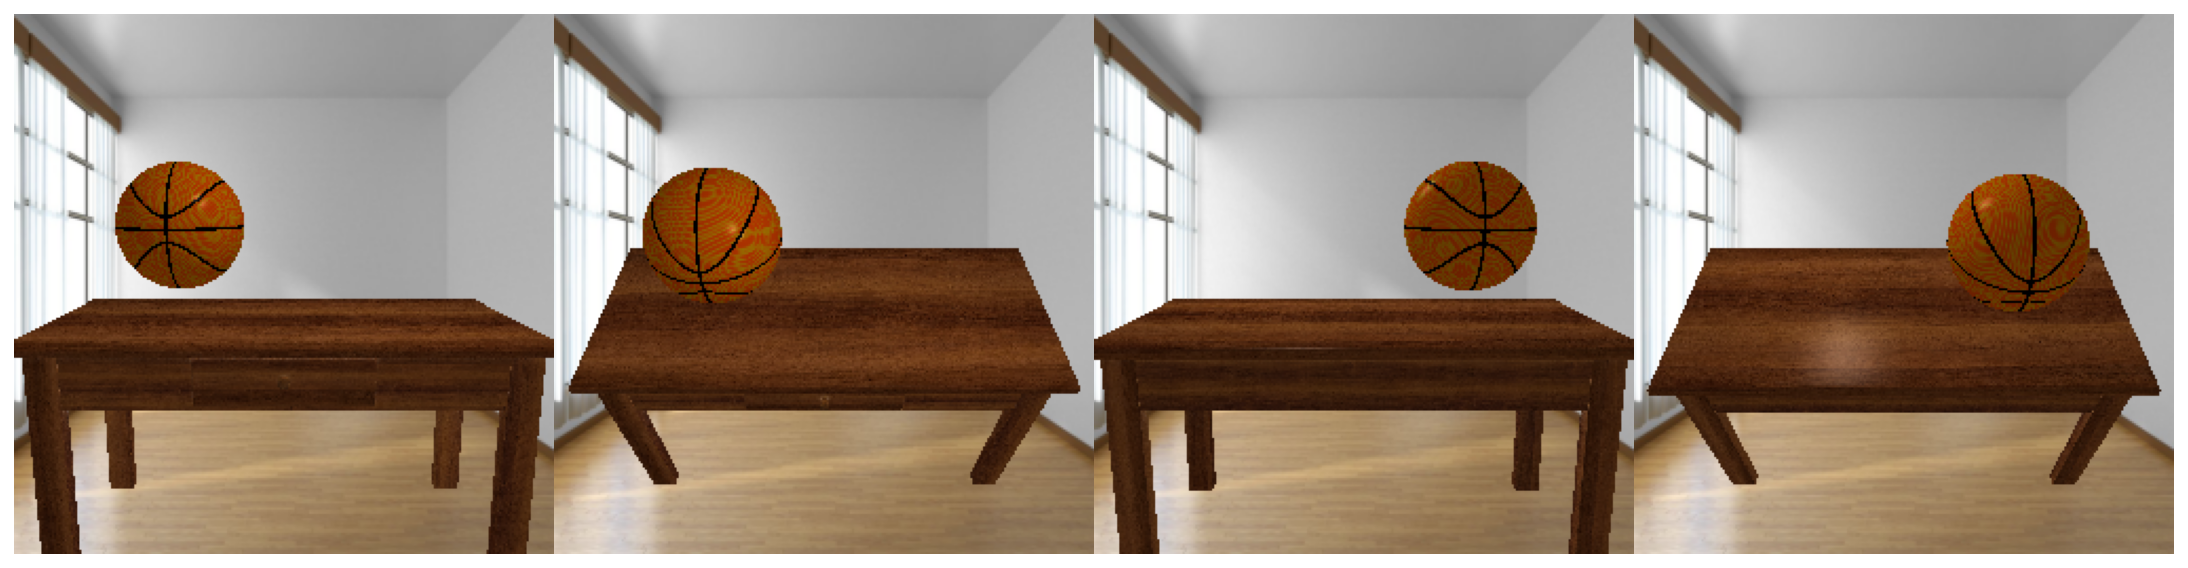

In [182]:
# images, scene = get_scene(rand_env.background_img, rand_env.objs, rand_env.best_pos)
images, scene = get_scene(rand_env.background_img, rand_env.objs, [a.position for a in rand_env.objs])
cuda.empty_cache()
image_grid(images, rows=1, cols=4, rgb=True)

In [72]:
import ray

ray.shutdown()
ray.init(ignore_reinit_error=True)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-08-26 10:26:17,097	INFO worker.py:1421 -- Started a local Ray instance.


Python version:,3.7.13
Ray version:,3.0.0.dev0


In [183]:
from ray.tune.registry import register_env

def discrete_env_creator(args):
  return CustomTrain(50)


register_env("discrete_clip_guided", discrete_env_creator)

In [201]:
from ray.rllib.algorithms.dqn import DQN
cuda.empty_cache()
dqn_agent = DQN(
    env="discrete_clip_guided",
    config={
        # 'num_atoms': 10,
        'v_max': 20,
        'v_min': -20,
        "num_workers": 0,
        "num_gpus": 1,
        'hiddens': [256],
        "gamma": 0.40,
        "n_step": 50,
        "framework": "torch",
        # "noisy": True,
        # 'grad_clip': 10.0,
        'min_train_timesteps_per_iteration': 2000,
        'metrics_num_episodes_for_smoothing': 3,
        'horizon': 50,
        # 'lr': 0.02,
        'train_batch_size': 50,
        # "prioritized_replay_alpha": 0.8,
        # "prioritized_replay_beta": 0.6
    },
)
cuda.empty_cache()

2022-08-26 11:30:26,495	WARNING deprecation.py:48 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2022-08-26 11:30:32,868	WARNING util.py:65 -- Install gputil for GPU system monitoring.


0.30371970841559714 [0.2333, 0.1362, 0.2379, 0.12213] [0.1823883056640625, 0.037410736083984375, 0.6292724609375, 0.15093994140625]


In [214]:
result = dqn_agent.train()
cuda.empty_cache()

0.4102569062855067 [0.321, 0.1506, 0.2834, 0.1216] [0.21917724609375, 0.040771484375, 0.5928955078125, 0.1471405029296875]
0.4102569062855067 [0.321, 0.1506, 0.2834, 0.1216] [0.21917724609375, 0.040771484375, 0.5928955078125, 0.1471405029296875]
0.09359846900155136 [0.2272, 0.2, 0.2073, 0.175] [0.202362060546875, 0.037322998046875, 0.645751953125, 0.11456298828125]
0.29240685917633585 [0.3606, 0.1831, 0.2454, 0.1722] [0.240325927734375, 0.0385589599609375, 0.6136474609375, 0.10736846923828125]
0.3945474277096298 [0.2712, 0.1249, 0.2256, 0.1053] [0.1817474365234375, 0.0399627685546875, 0.6488037109375, 0.12943267822265625]
0.311262594717717 [0.2754, 0.1506, 0.2341, 0.1285] [0.197174072265625, 0.0403289794921875, 0.616943359375, 0.145538330078125]
0.311262594717717 [0.2754, 0.1506, 0.2341, 0.1285] [0.197174072265625, 0.0403289794921875, 0.616943359375, 0.145538330078125]
0.17623364577081904 [0.3228, 0.2458, 0.2014, 0.2861] [0.2640380859375, 0.043182373046875, 0.6107177734375, 0.082107543

In [215]:
result

{'custom_metrics': {},
 'episode_media': {},
 'num_recreated_workers': 0,
 'info': {'learner': {'default_policy': {'custom_metrics': {},
    'learner_stats': {'mean_q': 0.009761901572346687,
     'min_q': -0.21195687353610992,
     'max_q': 0.2206059992313385,
     'cur_lr': 0.0005},
    'model': {},
    'td_error': array([ 1.13285005e-01, -7.79394031e-01, -1.63152605e-01, -2.11956874e-01,
           -2.36138701e-04,  1.07391141e-02,  1.17815696e-01,  7.75682479e-02,
           -8.65669549e-01, -3.31449136e-02,  1.01208918e-01, -1.34047791e-01,
            7.26643801e-02, -9.77479368e-02, -4.61994410e-02, -1.99349284e-01,
            4.24028933e-03,  1.69813529e-01,  2.13941962e-01,  3.56447771e-02,
           -1.01396948e-01, -1.25788059e-02,  4.64199036e-02, -1.39786780e-01,
           -7.77534172e-02,  8.32385719e-02, -8.26674104e-01, -1.38003364e-01,
           -6.58356026e-02,  9.54491794e-02, -5.26625663e-02, -9.11867738e-01,
           -4.08797339e-02, -6.32866919e-02, -6.340339

In [221]:
test_env = CustomTrain(10)

In [222]:
done=False

obs = test_env.reset()
while not done:
  action = {}
  action = dqn_agent.compute_single_action(obs, policy_id='default_policy')
  obs, reward, done, info = test_env.step(action)

0.10817996954905623 [0.608, 0.5117, 0.5923, 0.4666] [0.54461669921875, 0.0455322265625, 0.30755615234375, 0.102386474609375]


In [223]:
cuda.empty_cache()

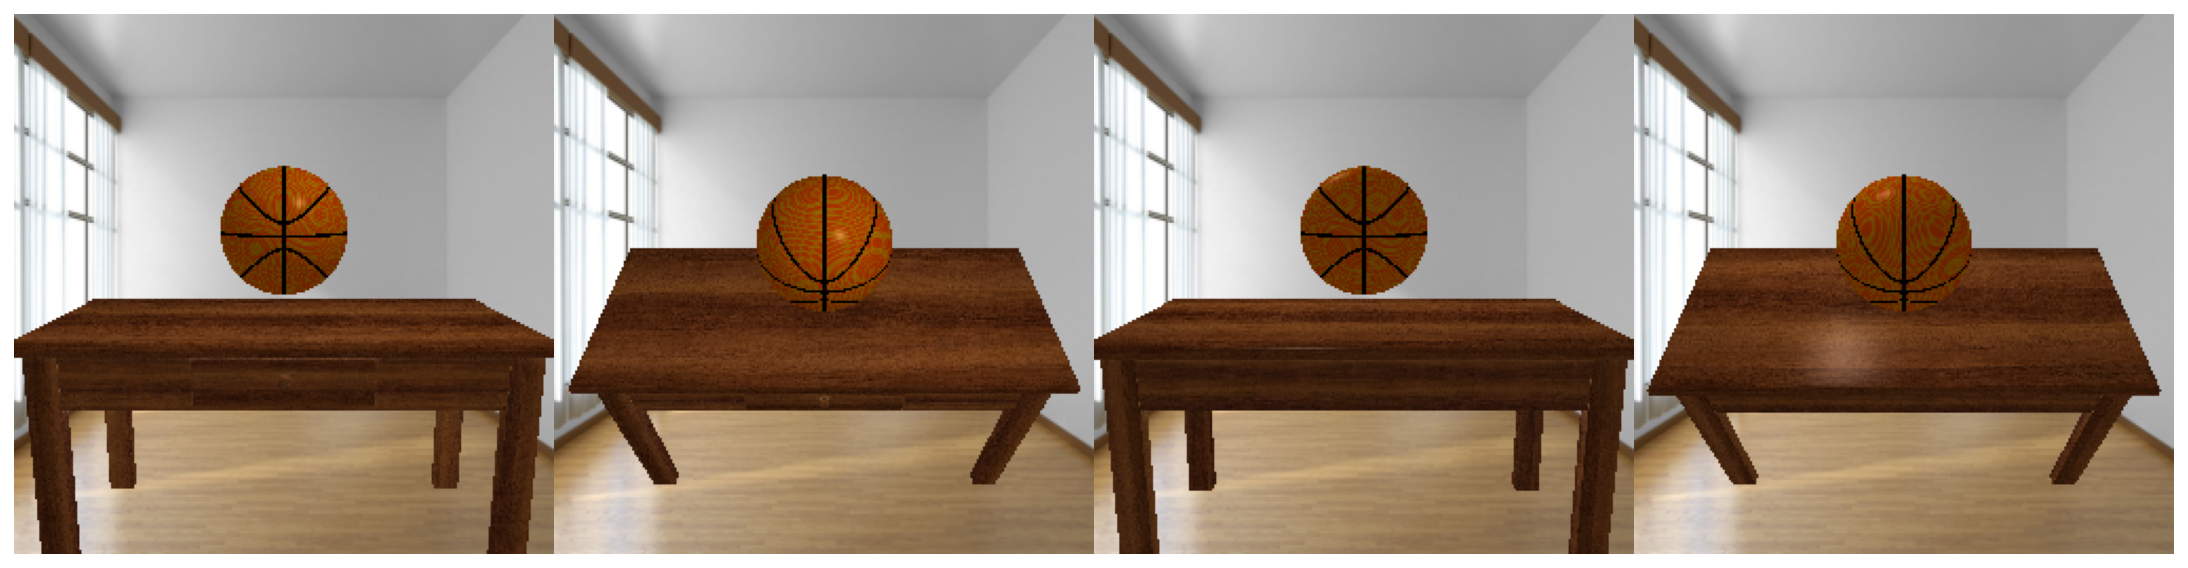

In [224]:
images, scene = get_scene(test_env.background_img, test_env.objs, test_env.best_pos)
cuda.empty_cache()
image_grid(images, rows=1, cols=4, rgb=True)